In [3]:
from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')


import os
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd

import zipfile
import requests
import io

# functions to help read in add health data
# (which is assumed to be stored under data/)
import add_health.add_health as add_health

## Functions to help load data

In [4]:
# EXCEPTIONS: networks 1 and 48 have formatting problems, so we'll omit them today
# this will take a few seconds

add_health_ids = [x for x in range(2, 85) if x != 48]
add_health_networks = [add_health.read_add_health_network(x) for x in add_health_ids]

## Configuration model

We have seen that the Erdos-Renyi random network model can produce networks that have a degree distribution with a characteristic shape, called the *Poisson* distribution.

Although some real-world networks have degree distributions that are well-approximated by a Poisson distribution, many do not. We would like a model that can generate networks that are random, but whose degree distributions match what we see in some real-world network. The *configuration model* can be helpful in this situation.

To explore the configuration model, we'll start with the network from one of the Add Health schools:

In [28]:
cur_network = add_health_networks[0]

We'll get a list with the degrees of the nodes in the network

In [29]:
def get_degree_list(g):
    return([deg_val for (node, deg_val) in g.degree()])

In [30]:
def plot_degree_list(deg_list, **kwargs):
    Table().with_column('degree', deg_list).hist(**kwargs)

In [31]:
def compare_degree_lists(name1, deg_list1, name2, deg_list2, **kwargs):
    Table().with_column(name1, deg_list1).with_column(name2, deg_list2).hist(**kwargs)

In [46]:
cur_network_degrees = get_degree_list(cur_network)
cur_network_degrees

[5,
 6,
 1,
 7,
 10,
 14,
 6,
 3,
 12,
 12,
 11,
 9,
 6,
 7,
 6,
 5,
 6,
 7,
 15,
 14,
 11,
 13,
 20,
 17,
 20,
 13,
 10,
 13,
 10,
 5,
 5,
 8,
 11,
 11,
 2,
 6,
 9,
 7,
 5,
 5,
 8,
 4,
 11,
 9,
 13,
 3,
 2,
 5,
 7,
 5,
 9,
 8,
 7,
 2,
 7,
 8,
 9,
 4,
 1,
 1,
 5,
 9,
 5,
 5,
 5,
 9,
 4,
 3,
 1,
 4,
 11,
 7,
 6,
 6,
 5,
 8,
 4,
 5,
 5,
 4,
 8,
 4,
 5,
 4,
 7,
 3,
 2,
 5,
 4,
 3,
 1,
 8,
 3,
 3,
 2,
 2,
 1,
 6,
 5,
 7,
 4,
 1,
 1,
 10,
 2]

It's helpful to visualize this as a histogram

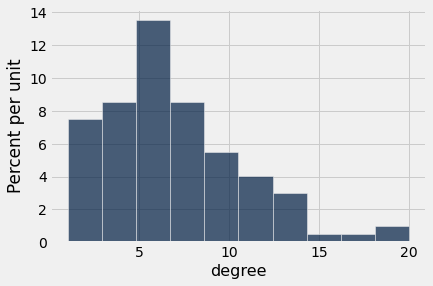

In [32]:
plot_degree_list(cur_network_degrees)

In [33]:
avg_degree = np.mean(cur_network_degrees)
avg_degree

6.647619047619048

In [34]:
num_nodes = cur_network.number_of_nodes()
num_nodes

105

Our network has 105 nodes and an average degree of about 6.5.

This suggests that a 'matching' ER network would have parameters

* $n = 105$ 
* $\bar{d} = 6.5 \Longleftrightarrow p = 6.5/104 = 0.0625$

### How well does ER approximate this network's degree distribution?

To investigate how well the ER model approximates this network's degree distribution, let's generate five ER networks with parameter values chosen to match the observed network. Then we'll plot the degree distribution from the ER network and compare it to the degree distribution of the real netowrk.

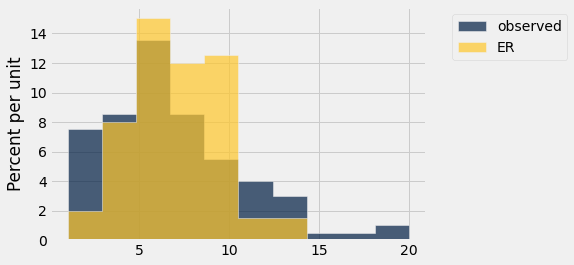

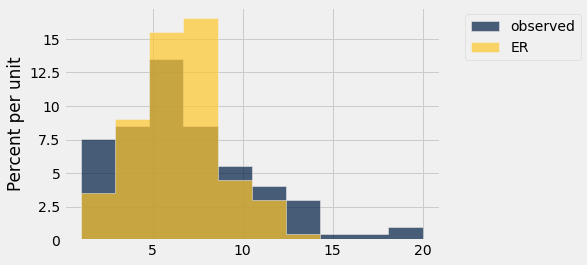

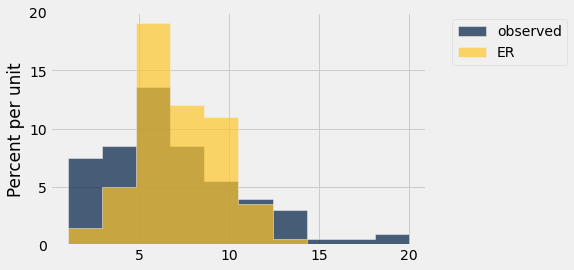

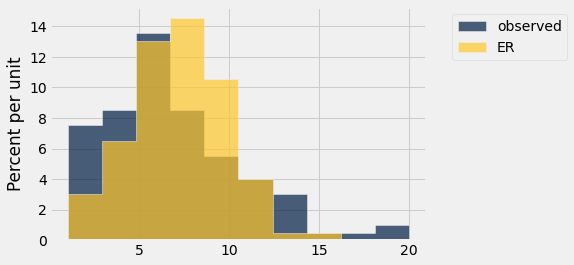

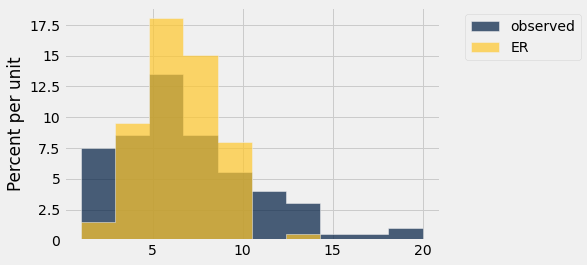

In [13]:
for i in range(5):
    er_graph = nx.erdos_renyi_graph(n=num_nodes, p = avg_degree/(num_nodes - 1) )
    er_degrees = get_degree_list(er_graph)
    #plot_degree_list(er_degrees)
    compare_degree_lists('observed', cur_network_degrees, 'ER', er_degrees)

The ER model appears to produce a degree distribution that is a little more peaked around the mean than the real network.

Now let's see if the configuration model can help us do better.

### Using the configuration model to more closely match the observed degree distribution

The **configuration model** was designed to help address this concern.

We can draw a network from the configuration model whose degree sequence matches the one we observed in the real Add Health dataset using the `nx.configuration_model` function:

In [36]:
config_model_graph = nx.configuration_model(cur_network_degrees)

Let's check that the random network generated by the configuration model matches our original network in two ways:

* it should have the same number of nodes
* it should have the same degrees

In [37]:
config_model_graph.number_of_nodes()

105

In [38]:
config_model_degree_list = get_degree_list(config_model_graph)
cur_network_degrees == config_model_degree_list

True

So we see that the degree sequence is exactly the same in the Add Health network and the network drawn from the configuration model.

To see this another way, when we plot the two degree distributions, we find that they are identical:

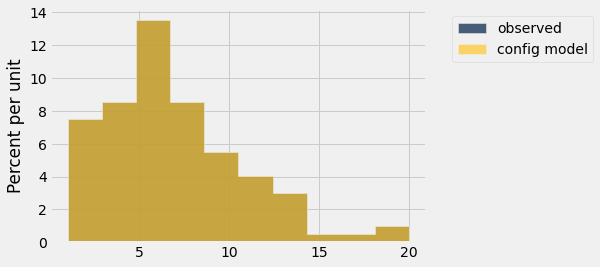

In [39]:
compare_degree_lists('observed', cur_network_degrees, 'config model', config_model_degree_list)

(We can't see the 'observed' distribution because it is completely covered up by the 'config model' distribution)

Let's look a little more closely at the network we drew from the configuration model

In [18]:
config_model_graph

This produced a `MultiGraph`. If you check out the definition of a `MultiGraph`, you'll find that this is a type of graph that can have multiple edges between the same pair of nodes, and that can have self loops (edges that begin and end at the same node).

We will typically want to remove these - but when we do, we no longer expect the degree sequence to exactly match the one that we started from. Usually, this trade-off is worth making - but it can vary from situation to situation.

In [40]:
# get rid of self-loops and multiple edges
simple_config_model_graph = nx.Graph(config_model_graph)
simple_config_model_graph.remove_edges_from(nx.selfloop_edges(simple_config_model_graph))

Let's check to see if the degree sequence has changed:

In [41]:
simple_config_model_degree_list = get_degree_list(simple_config_model_graph)
cur_network_degrees == simple_config_model_degree_list

False

As we expected, it no longer perfectly agrees.

Let's visualize how different the degree distribution is

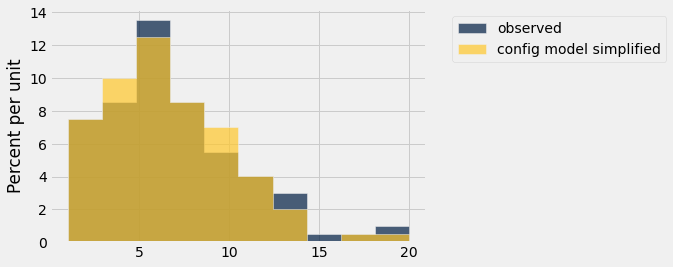

In [42]:
compare_degree_lists('observed', cur_network_degrees, 'config model simplified', simple_config_model_degree_list)

The two distributions are no longer identical, but they are very similar - much closer than the Poisson distribution produced by the ER model.

### Other properties of the configuration model

It seems very appealing that the configuration model can (more or less) replicate an observed degree sequence.

But, of course, we care about other properties of a network, too. Now, we will investigate a few possible properties to see if the configuration model seems to be able to capture them...

#### Clustering coefficient

Let's look at the clustering coefficient in the observed network

In [22]:
nx.average_clustering(cur_network)

0.3272140080830925

And the same quantity in the network drawn from the configuration model 

In [23]:
nx.average_clustering(simple_config_model_graph)

0.06752069281481049

That seems fairly different. But this is just from one realization of the configuration model. Let's see what the distribution is across many realizations from the model (all with degree sequences that match the observed network)

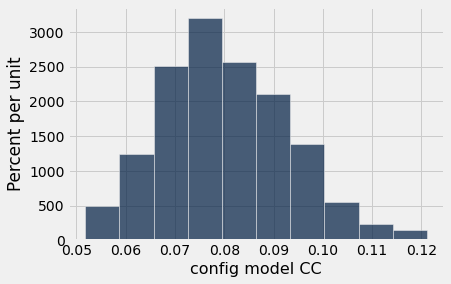

In [24]:
cc_res = make_array()

for i in range(500):
    cur_rand_config_model_graph = nx.configuration_model(cur_network_degrees)
    # simplify the graph by removing multi-edges and self loops
    cur_rand_config_model_graph = nx.Graph(cur_rand_config_model_graph)
    cur_rand_config_model_graph.remove_edges_from(nx.selfloop_edges(cur_rand_config_model_graph))
    cc_res = np.append(cc_res, nx.average_clustering(cur_rand_config_model_graph))
    
Table().with_column('config model CC', cc_res).hist()

Interesting. It looks like the configuration model **did not** capture the clustering that was present in the original network (see the Appendix to optionally read a little more).

#### Degree assortativity

Just to illustrate how the configuration model can be useful as a *null model*, let us investigate whether or not we find evidence of homophily by degree in the observed network. Homophily by degree - that is, a tendency for nodes with similar numbers of connections to be connected to each other - is often observed in real social networks. Some researchers call this phenomenon *degree assortativity*.

Let's look at the degree assortativity coefficient in the observed network

In [43]:
nx.degree_assortativity_coefficient(cur_network)

0.24716683025519798

This has the same interpretation as the assortativity coefficient we saw earlier in the semester, so this value suggests that there may be degree assortativity in the Add Health network.

Let's compare to the same quantity calculated in a network drawn from the configuration model 

In [44]:
nx.degree_assortativity_coefficient(simple_config_model_graph)

-0.007107513364921069

That seems fairly different. But this is just from one realization of the configuration model. Let's see what the distribution is across many realizations from the model (all with degree sequences that match the observed network)

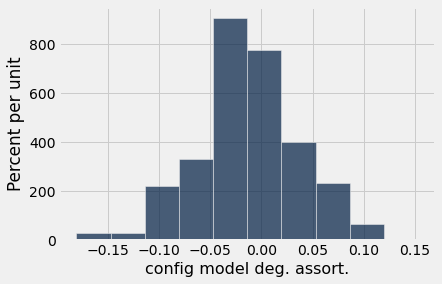

In [45]:
res = make_array()

for i in range(500):
    cur_rand_config_model_graph = nx.configuration_model(cur_network_degrees)
    res = np.append(res, nx.degree_assortativity_coefficient(cur_rand_config_model_graph))
    
Table().with_column('config model deg. assort.', res).hist()

It looks like the null model (i.e., the configuration model) suggests that degree assortativity would be about 0 if connections were formed completely at random, conditional on degree.  
So this suggests that, yes: there is some evidence of degree assortativity in the real Add Health network.

### Summary of configuration model

We started with a real-world network, and we wanted to be able to model that real-world network with some kind of random network model. (This might be useful if we wanted to come up with a null model for a hypothesis test, for example.)

We started with the ER model, but found that the degree distribution from the ER model was not a great match for the real world network.

So, we turned to the configuration model. A network generated from the configuration model perfectly matched the degree distribution in the real world network. Unfortunately, though, the network produced by the configuration model had self loops and multiple edges.

We removed the self loops and multiple edges to produce a network that was 'close' to the one drawn from the configuration model. We saw that this network still had a degree distribution that was very similar to the original Add Health network that we wanted to mimic.

We then used the configuration model as a null model to investigate two features of the real Add Health network: the clustering coefficient and the degree assortativity. In both cases, our analysis suggested that the observed, real-world clustering coefficient and degree assortativity were significantly different from what the null model implied.

## Appendix

(This is just in case you are curious - I wouldn't ask about this on a test.)

We did not derive this in class, but it turns out that there is an analytical expression for the clustering coefficient in networks drawn from the configuration model. It is

$
\begin{aligned}
\text{cc}_{\text{config}} = \frac{1}{n} \frac{ \left[ <k^2> - <k> \right]^2}{<k^3>},
\end{aligned}
$

where $<k>$ is the average degree (a quantity we have also called $\bar{d}$), $<k^2>$ is the average value of the squared degrees of the nodes in the network, and $<k^3>$ is the average value of the cubed degrees of the nodes in the network.

This expression is not as simple as the clustering coefficient we found in ER random networks. Nonetheless, if you inspect the equation, you will see that - like ER random networks - if the size of the network gets big (meaning $n \to \infty$), then the clustering coefficient will go to 0. This suggests that, just like the ER network, we should not expect that the configuration network will be able to capture the kind of relatively high clustering coefficients that we see in real-world social networks.


(This is derived in Mark Newman's wonderful book, *Networks: An Introduction*, pg 449.)